<a href="https://colab.research.google.com/github/elangbijak4/Image-Video-AI/blob/main/Demonstrasi_DETR_Image_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalasi pustaka yang diperlukan
!pip install transformers torch torchvision

In [ ]:
!pip install timm

In [6]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [7]:
# Import pustaka yang diperlukan
#import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [8]:
# Load model DETR dan prosesor gambar
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# Fungsi untuk menampilkan gambar dengan kotak deteksi
def plot_results(image, prob, boxes):
    plt.imshow(image)
    ax = plt.gca()
    colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k']

    # Tambahkan cetakan debug
    print("prob:", prob)
    print("boxes:", boxes)
    c = 'r'  # You can change this to any valid color code

    for i, (p, (xmin, ymin, xmax, ymax)) in enumerate(zip(prob, boxes.tolist())):
        print(f"Deteksi {i}: p={p}, box=({xmin}, {ymin}, {xmax}, {ymax})")
        ax.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=2))
        if isinstance(p, torch.Tensor):
            if p.numel() > 1:  # Check if p has more than one element
                cl = torch.argmax(p)
                text = f'{model.config.id2label[cl.item()]}: {p[cl].item():0.2f}'
            else:  # Handle the case where p is a scalar
                text = f'{model.config.id2label[0]}: {p.item():0.2f}'
        else:
            cl = p.index(max(p))  # Untuk kasus list
            text = f'{model.config.id2label[cl]}: {max(p):0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [10]:
# URL gambar contoh
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [11]:
# Proses gambar
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [12]:
# Peroleh prediksi
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

In [13]:
# Debugging: print ukuran dan tipe dari tensors
print("Results keys:", results.keys())
print("Scores shape:", results["scores"].shape)
print("Boxes shape:", results["boxes"].shape)

Results keys: dict_keys(['scores', 'labels', 'boxes'])
Scores shape: torch.Size([5])
Boxes shape: torch.Size([5, 4])


In [14]:
# Filter prediksi dengan probabilitas tinggi
prob_threshold = 0.7
scores = results["scores"]
boxes = results["boxes"]

prob: tensor([0.9982, 0.9960, 0.9955, 0.9988, 0.9987], grad_fn=<IndexBackward0>)
boxes: tensor([[ 4.0163e+01,  7.0812e+01,  1.7555e+02,  1.1798e+02],
        [ 3.3324e+02,  7.2550e+01,  3.6833e+02,  1.8766e+02],
        [-2.2602e-02,  1.1496e+00,  6.3973e+02,  4.7376e+02],
        [ 1.3241e+01,  5.2055e+01,  3.1402e+02,  4.7093e+02],
        [ 3.4540e+02,  2.3854e+01,  6.4037e+02,  3.6872e+02]],
       grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9982202649116516, box=(40.163299560546875, 70.8115463256836, 175.54705810546875, 117.98412322998047)
Deteksi 1: p=0.9960021376609802, box=(333.2417297363281, 72.55009460449219, 368.32879638671875, 187.66360473632812)
Deteksi 2: p=0.9954743981361389, box=(-0.022602081298828125, 1.1496305465698242, 639.7271728515625, 473.7610778808594)
Deteksi 3: p=0.99880051612854, box=(13.240814208984375, 52.05467987060547, 314.0186767578125, 470.9273681640625)
Deteksi 4: p=0.9986783862113953, box=(345.40179443359375, 23.853778839111328, 640.3717041015625, 368.721

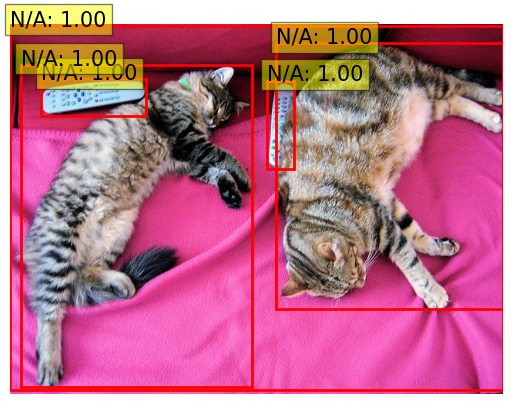

In [15]:
# Pastikan ada deteksi yang valid
if scores.numel() > 0 and boxes.numel() > 0:
    keep = scores > prob_threshold
    if keep.sum().item() > 0:  # Pastikan ada deteksi yang tersisa setelah filter
        # Filter tensor berdasarkan indeks yang dipilih
        filtered_scores = scores[keep]
        filtered_boxes = boxes[keep]
        # Tampilkan hasil
        plot_results(image, filtered_scores, filtered_boxes)
    else:
        print("Tidak ada deteksi dengan probabilitas di atas threshold.")
else:
    print("Tidak ada deteksi yang ditemukan.")

# Deteksi di dalam video

In [31]:
import cv2

--2024-06-21 15:50:00--  https://www.learningcontainer.com/wp-content/uploads/2020/05/sample-mp4-file.mp4
Resolving www.learningcontainer.com (www.learningcontainer.com)... 172.67.188.164, 104.21.84.74, 2606:4700:3033::ac43:bca4, ...
Connecting to www.learningcontainer.com (www.learningcontainer.com)|172.67.188.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10546620 (10M) [video/mp4]
Saving to: ‘sample_video.mp4’

sample_video.mp4    100%[===================>]  10.06M  --.-KB/s    in 0.1s    

2024-06-21 15:50:01 (86.6 MB/s) - ‘sample_video.mp4’ saved [10546620/10546620]

prob: tensor([0.7522, 0.9723], grad_fn=<IndexBackward0>)
boxes: tensor([[ 14.1323,  87.3310,  77.9788, 164.1130],
        [ 14.6910,  88.7613, 129.7373, 168.8708]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.7522068023681641, box=(14.132259368896484, 87.33100128173828, 77.97881317138672, 164.1129913330078)
Deteksi 1: p=0.9722936153411865, box=(14.691014289855957, 88.76129150390625, 129.737

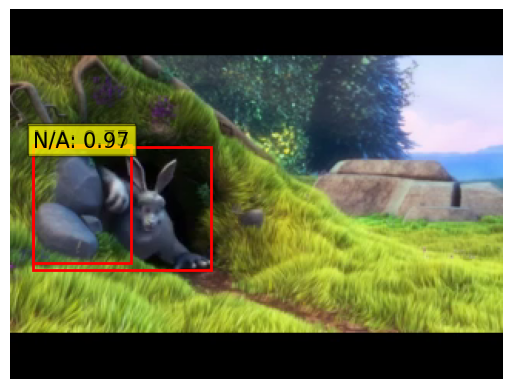

prob: tensor([0.8418], grad_fn=<IndexBackward0>)
boxes: tensor([[ 14.3951,  88.9117, 129.8082, 168.9588]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.8417624235153198, box=(14.395146369934082, 88.91173553466797, 129.8082275390625, 168.95884704589844)


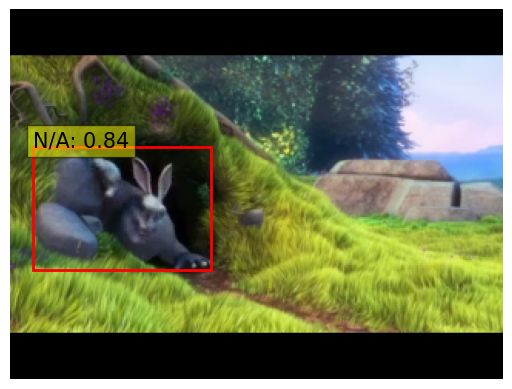

prob: tensor([0.8748], grad_fn=<IndexBackward0>)
boxes: tensor([[ 14.7283,  89.3170, 130.1761, 170.1360]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.8747569918632507, box=(14.728336334228516, 89.31700134277344, 130.17611694335938, 170.135986328125)


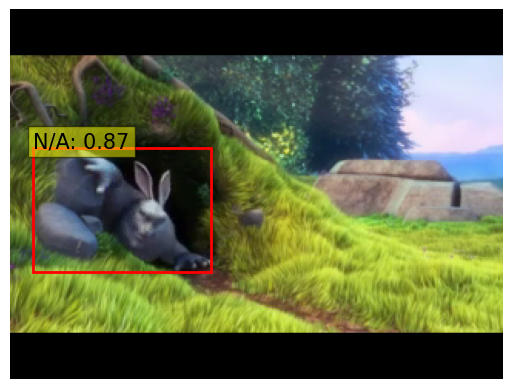

Tidak ada deteksi yang ditemukan.
prob: tensor([0.7422], grad_fn=<IndexBackward0>)
boxes: tensor([[ 14.5087,  93.5423, 133.4125, 170.3137]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.7422353029251099, box=(14.508695602416992, 93.54232025146484, 133.41246032714844, 170.31369018554688)


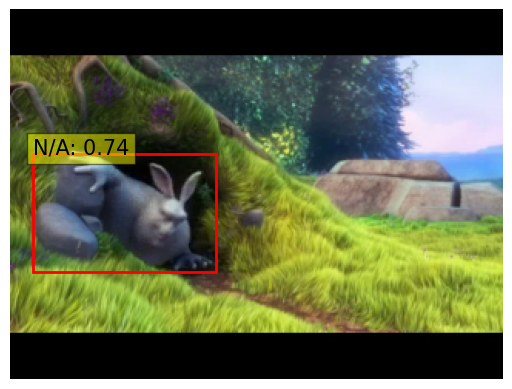

prob: tensor([0.7415, 0.8335, 0.9571, 0.9441], grad_fn=<IndexBackward0>)
boxes: tensor([[ 16.3749,  91.1788, 164.0901, 170.7464],
        [ 83.1951,  95.4095, 133.4738, 170.2664],
        [ 20.5704,  91.9391, 135.2732, 170.3125],
        [ 30.7329,  27.5599, 169.0430, 171.2131]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.7414842844009399, box=(16.374893188476562, 91.17882537841797, 164.09010314941406, 170.74636840820312)
Deteksi 1: p=0.8335093259811401, box=(83.19511413574219, 95.40953826904297, 133.47378540039062, 170.26637268066406)
Deteksi 2: p=0.9570650458335876, box=(20.570415496826172, 91.93911743164062, 135.27320861816406, 170.31248474121094)
Deteksi 3: p=0.9441477060317993, box=(30.73290252685547, 27.559940338134766, 169.04299926757812, 171.2130889892578)


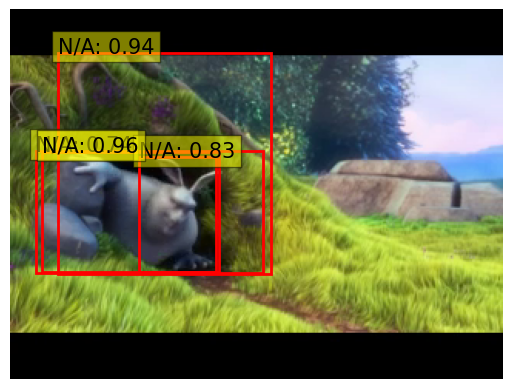

prob: tensor([0.9348, 0.7635], grad_fn=<IndexBackward0>)
boxes: tensor([[ 24.8082,  89.3124, 138.6889, 170.4760],
        [ 36.3371,  27.8281, 167.0534, 170.6784]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9348459243774414, box=(24.80818748474121, 89.3123550415039, 138.68890380859375, 170.4759979248047)
Deteksi 1: p=0.7634695768356323, box=(36.33709716796875, 27.828054428100586, 167.05337524414062, 170.67843627929688)


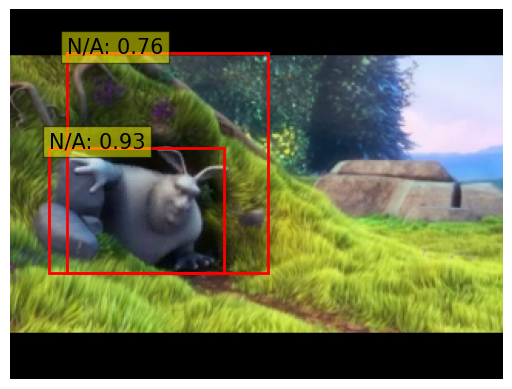

prob: tensor([0.8803, 0.9547], grad_fn=<IndexBackward0>)
boxes: tensor([[ 15.1184,  88.6461, 135.1037, 169.6838],
        [ 30.7394,  27.9420, 168.7299, 171.2054]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.8803439140319824, box=(15.118446350097656, 88.64610290527344, 135.1037139892578, 169.68377685546875)
Deteksi 1: p=0.9546879529953003, box=(30.739364624023438, 27.941951751708984, 168.72991943359375, 171.20542907714844)


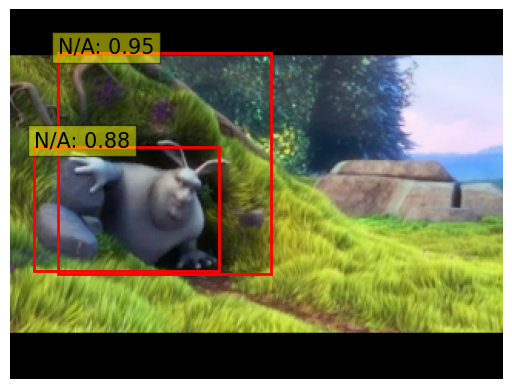

Tidak ada deteksi dengan probabilitas di atas threshold.
prob: tensor([0.9129], grad_fn=<IndexBackward0>)
boxes: tensor([[ 14.9574,  73.3700, 140.6032, 170.8136]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9129346609115601, box=(14.957385063171387, 73.37004852294922, 140.60324096679688, 170.8135986328125)


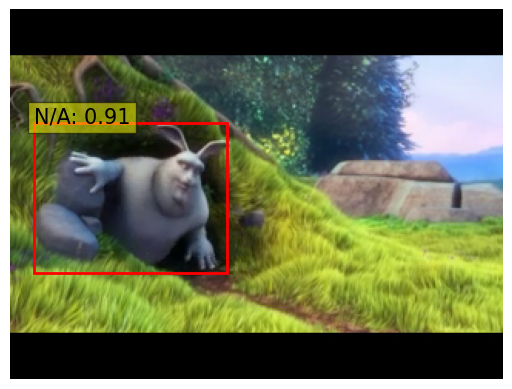

Tidak ada deteksi dengan probabilitas di atas threshold.
prob: tensor([0.8650, 0.7620, 0.9917, 0.9459], grad_fn=<IndexBackward0>)
boxes: tensor([[3.7831e+01, 2.8340e+01, 1.4670e+02, 9.4341e+01],
        [1.5020e-02, 3.8780e+01, 3.0516e+01, 8.9121e+01],
        [1.5333e+01, 6.5937e+01, 1.4465e+02, 1.7549e+02],
        [1.9739e+02, 9.8277e+01, 2.9866e+02, 1.3891e+02]],
       grad_fn=<IndexBackward0>)
Deteksi 0: p=0.8649832010269165, box=(37.83056640625, 28.33978843688965, 146.699462890625, 94.34056091308594)
Deteksi 1: p=0.7619776129722595, box=(0.015020370483398438, 38.780372619628906, 30.516042709350586, 89.1208267211914)
Deteksi 2: p=0.9917469024658203, box=(15.332508087158203, 65.93736267089844, 144.645751953125, 175.4904327392578)
Deteksi 3: p=0.9459103345870972, box=(197.3853759765625, 98.27689361572266, 298.6595458984375, 138.91049194335938)


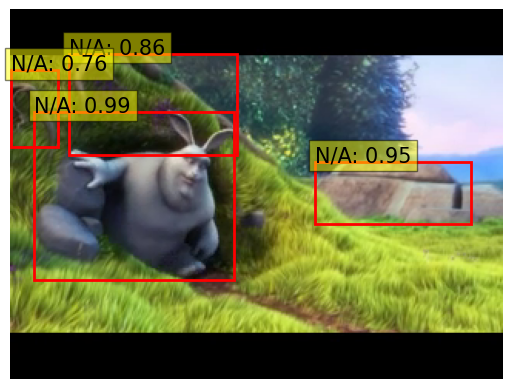

prob: tensor([0.9039, 0.7072, 0.9906], grad_fn=<IndexBackward0>)
boxes: tensor([[1.9749e+02, 9.8114e+01, 2.9673e+02, 1.3870e+02],
        [1.9907e-02, 4.1670e+01, 3.0843e+01, 9.0067e+01],
        [1.4981e+01, 6.5592e+01, 1.4580e+02, 1.7672e+02]],
       grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9039158225059509, box=(197.488525390625, 98.1143798828125, 296.7271423339844, 138.70436096191406)
Deteksi 1: p=0.7072219252586365, box=(0.01990675926208496, 41.669925689697266, 30.843482971191406, 90.06690216064453)
Deteksi 2: p=0.9905688166618347, box=(14.981083869934082, 65.59215545654297, 145.7990264892578, 176.72129821777344)


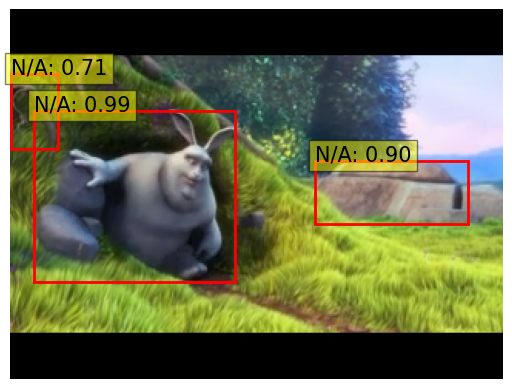

Tidak ada deteksi dengan probabilitas di atas threshold.
Tidak ada deteksi yang ditemukan.
prob: tensor([0.9171], grad_fn=<IndexBackward0>)
boxes: tensor([[ 16.0059,  78.1317, 148.6735, 177.8323]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9170728921890259, box=(16.005878448486328, 78.13165283203125, 148.67349243164062, 177.83226013183594)


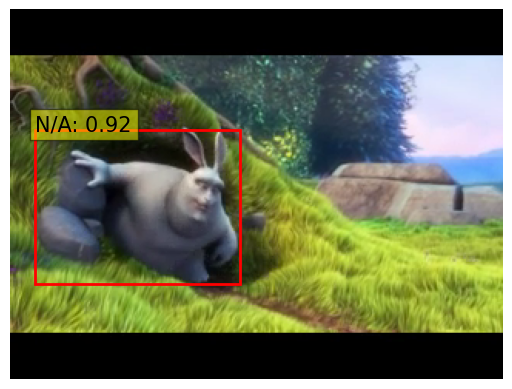

prob: tensor([0.9659], grad_fn=<IndexBackward0>)
boxes: tensor([[ 18.6645,  90.0438, 152.8096, 178.7324]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9658851027488708, box=(18.664478302001953, 90.04379272460938, 152.8095703125, 178.73236083984375)


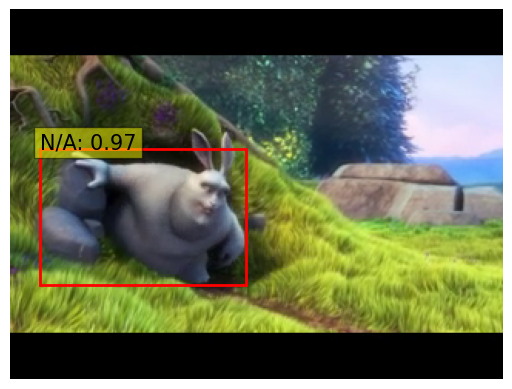

prob: tensor([0.7764], grad_fn=<IndexBackward0>)
boxes: tensor([[ 16.8045,  77.3112, 155.6114, 178.3617]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.7763739824295044, box=(16.804466247558594, 77.31120300292969, 155.6114044189453, 178.3617401123047)


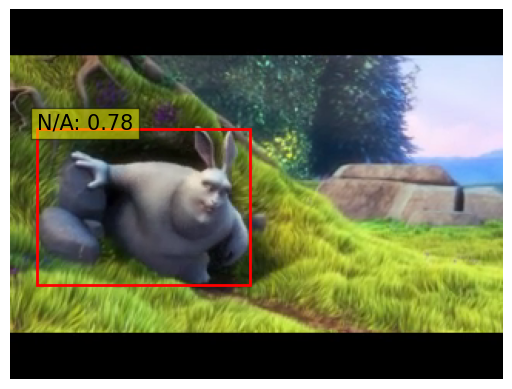

prob: tensor([0.8680], grad_fn=<IndexBackward0>)
boxes: tensor([[ 16.3232,  94.5338, 160.7173, 181.5082]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.868000328540802, box=(16.32318115234375, 94.53382110595703, 160.71731567382812, 181.5082244873047)


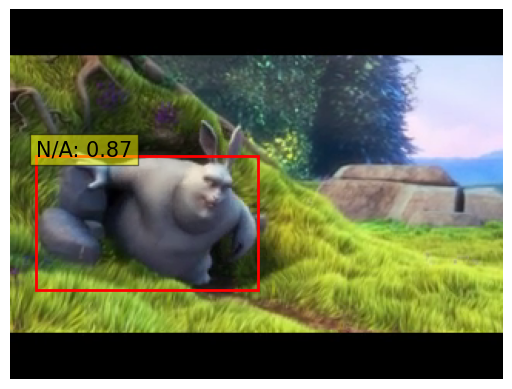

prob: tensor([0.8083, 0.8298], grad_fn=<IndexBackward0>)
boxes: tensor([[ 16.8492,  93.6619, 164.0675, 182.9138],
        [ 33.6361,  71.9904, 165.6324, 183.1230]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.8083027005195618, box=(16.849151611328125, 93.661865234375, 164.06753540039062, 182.91384887695312)
Deteksi 1: p=0.8297550678253174, box=(33.636085510253906, 71.99044799804688, 165.6324005126953, 183.1229705810547)


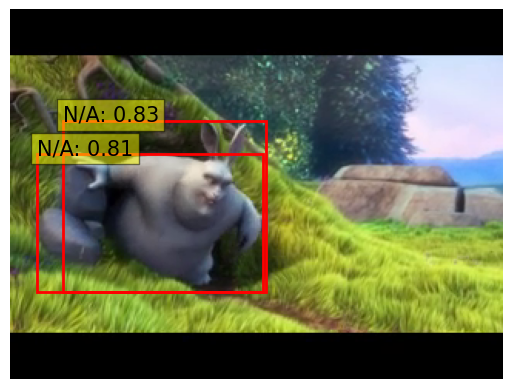

prob: tensor([0.7722], grad_fn=<IndexBackward0>)
boxes: tensor([[ 34.2885,  89.0643, 168.0968, 182.5693]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.772150456905365, box=(34.28852462768555, 89.06428527832031, 168.0968475341797, 182.56930541992188)


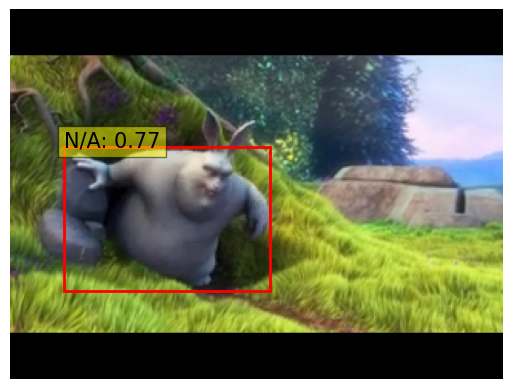

Tidak ada deteksi dengan probabilitas di atas threshold.
prob: tensor([0.9397, 0.9675], grad_fn=<IndexBackward0>)
boxes: tensor([[150.2666, 133.3350, 168.1059, 147.7831],
        [ 40.5343,  51.2186, 173.8898, 181.5753]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9396741986274719, box=(150.2666015625, 133.33499145507812, 168.10589599609375, 147.78306579589844)
Deteksi 1: p=0.9674638509750366, box=(40.53434371948242, 51.218563079833984, 173.88975524902344, 181.57533264160156)


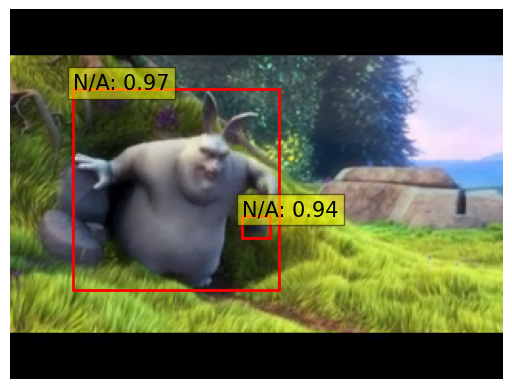

prob: tensor([0.8460, 0.9778], grad_fn=<IndexBackward0>)
boxes: tensor([[ 18.3007,  46.8201, 176.3168, 180.4130],
        [ 28.4016,  45.1884, 177.1826, 180.9035]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.845974862575531, box=(18.300676345825195, 46.82007598876953, 176.31675720214844, 180.4129638671875)
Deteksi 1: p=0.9778132438659668, box=(28.40164566040039, 45.18840026855469, 177.18260192871094, 180.90350341796875)


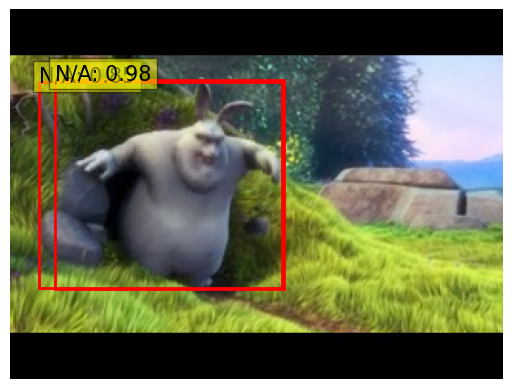

prob: tensor([0.9419, 0.9807], grad_fn=<IndexBackward0>)
boxes: tensor([[ 47.7152,  39.5498, 176.8161, 181.1450],
        [ 18.4722,  38.7335, 176.3797, 180.9982]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9418731927871704, box=(47.71524429321289, 39.549842834472656, 176.81607055664062, 181.14498901367188)
Deteksi 1: p=0.9806932806968689, box=(18.472185134887695, 38.73348617553711, 176.37966918945312, 180.99818420410156)


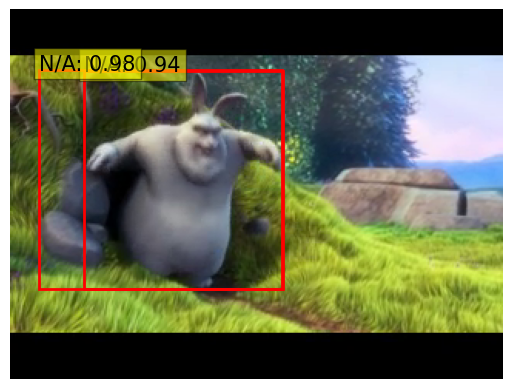

Tidak ada deteksi dengan probabilitas di atas threshold.
prob: tensor([0.7319, 0.7379, 0.8536, 0.8707], grad_fn=<IndexBackward0>)
boxes: tensor([[-8.1099e-02,  3.2664e+01,  3.6410e+01,  9.4211e+01],
        [ 5.3450e+01,  2.9762e+01,  1.1289e+02,  7.7909e+01],
        [ 1.9174e+01,  3.6365e+01,  1.6995e+02,  1.8246e+02],
        [ 6.4986e+01,  3.0347e+01,  1.1442e+02,  6.3852e+01]],
       grad_fn=<IndexBackward0>)
Deteksi 0: p=0.7318605780601501, box=(-0.08109927177429199, 32.66390609741211, 36.41023635864258, 94.2105712890625)
Deteksi 1: p=0.7378636598587036, box=(53.44967269897461, 29.76225471496582, 112.89277648925781, 77.9087142944336)
Deteksi 2: p=0.8536467552185059, box=(19.173622131347656, 36.364715576171875, 169.9453125, 182.45697021484375)
Deteksi 3: p=0.8706645965576172, box=(64.98623657226562, 30.346948623657227, 114.42158508300781, 63.851966857910156)


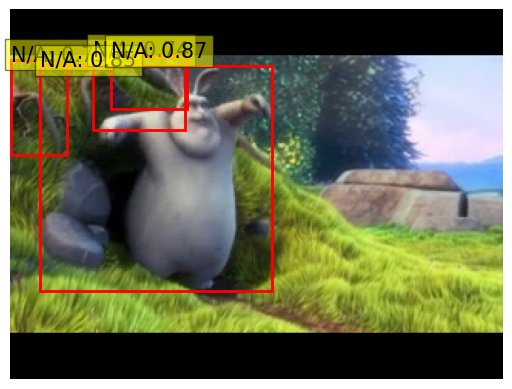

Tidak ada deteksi yang ditemukan.
Tidak ada deteksi yang ditemukan.
Tidak ada deteksi yang ditemukan.
prob: tensor([0.7596], grad_fn=<IndexBackward0>)
boxes: tensor([[ 19.2662,  32.3810, 150.6532, 182.5768]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.7595776319503784, box=(19.26620864868164, 32.38102340698242, 150.65316772460938, 182.57681274414062)


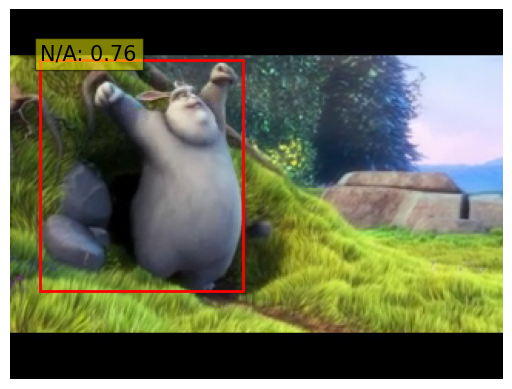

prob: tensor([0.7070], grad_fn=<IndexBackward0>)
boxes: tensor([[-5.1616e-02,  4.2256e+01,  3.7049e+01,  9.4042e+01]],
       grad_fn=<IndexBackward0>)
Deteksi 0: p=0.7070163488388062, box=(-0.05161643028259277, 42.25559997558594, 37.048553466796875, 94.04190063476562)


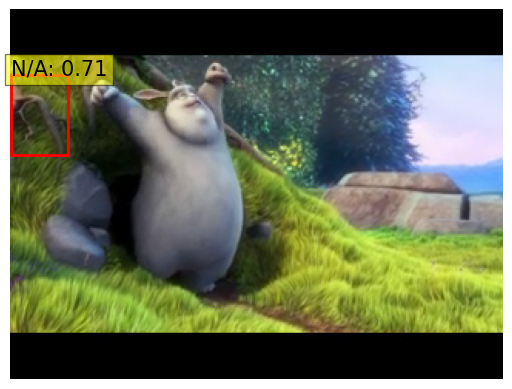

prob: tensor([0.9839], grad_fn=<IndexBackward0>)
boxes: tensor([[ 49.4180,  32.9013, 152.2397, 183.6938]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.9838809370994568, box=(49.41799545288086, 32.90126419067383, 152.23974609375, 183.69384765625)


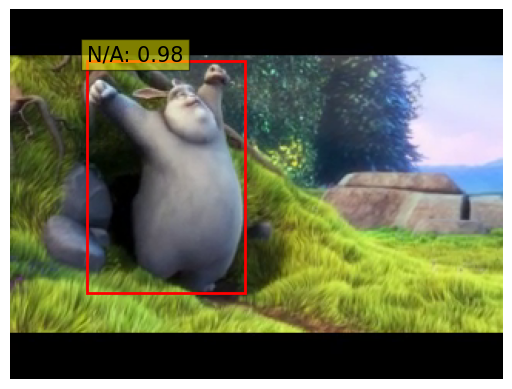

prob: tensor([0.7403], grad_fn=<IndexBackward0>)
boxes: tensor([[ 50.3161,  36.8790, 153.0539, 184.7498]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.7403030395507812, box=(50.31608581542969, 36.87904357910156, 153.05386352539062, 184.74981689453125)


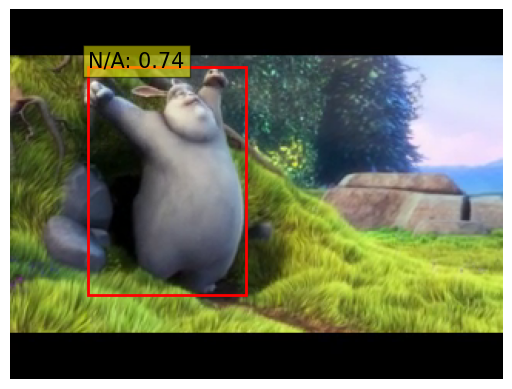

prob: tensor([0.8786, 0.7314], grad_fn=<IndexBackward0>)
boxes: tensor([[ 49.3663,  37.6035, 153.4333, 184.2222],
        [ 48.4226,  30.3693, 153.0302, 183.6041]], grad_fn=<IndexBackward0>)
Deteksi 0: p=0.8786348700523376, box=(49.36634063720703, 37.603511810302734, 153.43325805664062, 184.2222137451172)
Deteksi 1: p=0.7314028143882751, box=(48.4226188659668, 30.36933708190918, 153.03021240234375, 183.60411071777344)


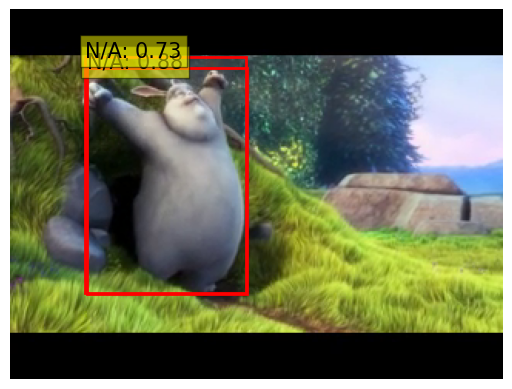

Tidak ada deteksi dengan probabilitas di atas threshold.
Tidak ada deteksi dengan probabilitas di atas threshold.
Tidak ada deteksi dengan probabilitas di atas threshold.


In [ ]:
# URL video contoh
video_url = "https://www.learningcontainer.com/wp-content/uploads/2020/05/sample-mp4-file.mp4"
video_path = "sample_video.mp4"

# Download video
!wget {video_url} -O {video_path}

# Baca video menggunakan OpenCV
cap = cv2.VideoCapture(video_path)

# Proses setiap frame dalam video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame ke format yang bisa diproses oleh PIL
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(frame_rgb)

    # Proses gambar
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Peroleh prediksi
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

    # Filter prediksi dengan probabilitas tinggi
    prob_threshold = 0.7
    scores = results["scores"]
    boxes = results["boxes"]

    # Pastikan ada deteksi yang valid
    if scores.numel() > 0 and boxes.numel() > 0:
        keep = scores > prob_threshold
        if keep.sum().item() > 0:  # Pastikan ada deteksi yang tersisa setelah filter
            # Filter tensor berdasarkan indeks yang dipilih
            filtered_scores = scores[keep]
            filtered_boxes = boxes[keep]
            # Tampilkan hasil
            plot_results(image, filtered_scores, filtered_boxes)
        else:
            print("Tidak ada deteksi dengan probabilitas di atas threshold.")
    else:
        print("Tidak ada deteksi yang ditemukan.")

cap.release()
cv2.destroyAllWindows()